In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fbprophet import Prophet
from datetime import datetime
import datetime

%matplotlib inline

In [2]:
df = pd.read_csv("final_tcs.csv")
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,DOWJONES,NASDAQ,NSE
0,14-03-2017,2556.800049,2587.149902,2551.050049,2567.500000,2519.130615,1701147,20837.36914,5856.819824,9087.000000
1,15-03-2017,2572.000000,2572.149902,2493.850098,2498.300049,2451.234131,1511248,20950.09961,5900.049805,9084.799805
2,16-03-2017,2506.000000,2527.000000,2506.000000,2520.899902,2473.408447,785909,20934.55078,5900.759766,9153.700195
3,17-03-2017,2546.000000,2546.000000,2509.750000,2525.750000,2478.167236,1296576,20914.61914,5901.000000,9160.049805
4,20-03-2017,2525.949951,2525.949951,2466.000000,2480.000000,2433.279297,1743770,20905.85938,5901.529785,9126.849609


In [3]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,DOWJONES,NASDAQ,NSE
242,05-03-2018,3037.699951,3113.649902,3032.949951,3105.850098,3105.850098,1429084,24874.75977,7330.709961,10358.84961
243,06-03-2018,3122.000000,3127.000000,3030.149902,3042.800049,3042.800049,953382,24884.11914,7372.009766,10249.25000
244,07-03-2018,3070.000000,3089.000000,3018.500000,3027.449951,3027.449951,958886,24801.35938,7396.649902,10154.20020
245,08-03-2018,3054.899902,3054.899902,2987.500000,3003.949951,3003.949951,975913,24895.21094,7427.950195,10242.65039
246,09-03-2018,3005.000000,3063.199951,2977.199951,3034.100098,3034.100098,936218,25335.74023,7560.810059,10226.84961


In [4]:
df.shape

(247, 10)

In [5]:
#Function for difference between current day's opening price and previous day's closing price
def pcod(stock):
    stock['pcod'] = stock['Open'] - stock['Close'].shift(1)
    return stock

In [6]:
#Function for difference between current day's highest price and lowest price
def hld(stock):
    stock['hld'] = stock['High'] - stock['Low']
    return stock

In [7]:
# Function for Relative Strength Index
def stockRsi(stock, numOfDays): 
    
    delta = stock['Close'].diff()
    
    deltaUp = np.where(delta>0, delta, 0)
    deltaDown = np.where(delta<0, delta, 0)
    
    dfDeltaUp = pd.DataFrame(data=deltaUp, columns=['deltaUp'])
    dfDeltaDown = pd.DataFrame(data=deltaDown, columns=['deltaDown'])
    
    rollingDf = pd.DataFrame(np.zeros, index=range(0,len(stock['Close'])), 
                             columns=['rollingUp','rollingDown'])
    
    rollingDf['rollingUp'] = dfDeltaUp.rolling(window=numOfDays).mean()
    #rollingDf['rollingUp'].fillna(0, inplace=True)
    
    rollingDf['rollingDown'] = dfDeltaDown.rolling(window=numOfDays).mean()
    #rollingDf['rollingDown'].fillna(0, inplace=True)
    
    rollingDf['RS'] = (rollingDf['rollingUp'] / rollingDf['rollingDown']).abs()
    
    rsi = 100.0 - (100.0/(1.0 + rollingDf['RS']))
            
    stock['rsi'] = rsi
    
    return stock


In [8]:
#Function to calculate bollinger bands average, upper and lower bands
def bbands(stock, length, numsd):
    """ returns average, upper band, and lower band"""
    avg = stock['Close'].rolling(window=length).mean()
    sd = stock['Close'].rolling(window=length).std()
    upband = avg + (sd*numsd)
    dnband = avg - (sd*numsd)
    stock['bbul'], stock['bbll'] = np.round(upband, 3), np.round(dnband, 3)
    return stock

In [9]:
# Function for short-term moving average
def stma(stock, numOfDays):
    stock['stma'] = stock['Close'].rolling(window=numOfDays).mean()
    return stock

In [10]:
# Function for long-term moving average
def ltma(stock, numOfDays):
    stock['ltma'] = stock['Close'].rolling(window=numOfDays).mean()
    return stock

In [11]:
#Function for exponential moving average
def ema(stock, numOfDays):
    stock['ema'] = stock['Close'].ewm(span=numOfDays, adjust=False, min_periods=numOfDays-1).mean()
    return stock

In [12]:
# Stock Crossed Upper-Limit
def scul(stock):
    stock['scul'] = stock.Close > stock.bbul
    stock['scul'] = stock['scul'].astype(int)
    return stock

In [13]:
# Stock Crossed Lower-Limit
def scll(stock):
    stock['scll'] = stock.Close < stock.bbll
    stock['scll'] = stock['scll'].astype(int)
    return stock

In [14]:
# short-term moving average cuts long-term moving average

def stma_cuts_ltma(stock):
    
    stma = stock['stma']
    ltma = stock['ltma']
    
    values1 = [] # stma cuts ltma from below 
    values2 = [] # stma cuts ltma from above 
    overlapping = []
    
    for k in range(0, len(stock)):                
        i = j = k
        
        if stma[i] == ltma[j]: # point of intersection  
            overlapping.append(1)
            
            if i == 0: # for the first datapoint
                values1.append(np.nan) # previous data point is not available
                values2.append(np.nan) # previous data point is not available
                
            elif (stma[i-1] > ltma[j-1]):  
                values2.append(1) # stma cuts ltma from above
                values1.append(0) # stma cuts ltma from below                
                
            elif (stma[i-1] < ltma[j-1]):         
                values1.append(1) # stma cuts ltma from below
                values2.append(0) # stma cuts ltma from above
                      
            elif stma[i-1] == ltma[j-1]:           
                values1.append(0) # stma cuts ltma from below
                values2.append(0) # stma cuts ltma from above
                
        else:
            overlapping.append(0)
            values1.append(0) # stma cuts ltma from below
            values2.append(0) # stma cuts ltma from above   
            
    # stma cuts ltma from below 
    stock['stma_cut_ltma_b'] = values1 
    
    # stma cuts ltma from above
    stock['stma_pr_cut_ltma_a'] = values2
    
    # stma overlaps ltma
    stock['stma_overlaps_ltma'] = overlapping
    
    return stock


In [15]:
# close price cuts short-term moving average

def close_cuts_stma(stock):
    
    close = stock['Close']
    stma = stock['stma']
    
    values1 = [] # close price cuts stma from below 
    values2 = [] # close price cuts stma from above 
    overlapping = []
    
    for k in range(0, len(stock)):                
        i = j = k
        
        if close[i] == stma[j]: # point of intersection  
            overlapping.append(1)
            
            if i == 0: # for the first datapoint
                values1.append(np.nan) # previous data point is not available
                values2.append(np.nan) # previous data point is not available
                
            elif (close[i-1] > stma[j-1]):  
                values2.append(1) # close price cuts stma from above
                values1.append(0) # close price cuts stma from below                
                
            elif (close[i-1] < stma[j-1]):         
                values1.append(1) # close price cuts stma from below
                values2.append(0) # close price cuts stma from above
                      
            elif close[i-1] == stma[j-1]:           
                values1.append(0) # close price cuts stma from below
                values2.append(0) # close price cuts stma from above
                
        else:
            overlapping.append(0)
            values1.append(0) # close price cuts stma from below
            values2.append(0) # close price cuts stma from above   
            
    # close price cuts stma from below 
    stock['close_pr_cut_stma_b'] = values1 
    
    # close price cuts stma from above
    stock['close_pr_cut_stma_a'] = values2
    
    # close price overlaps stma
    stock['close_pr_overlaps_stma'] = overlapping
    
    return stock


In [16]:
# close price cuts long-term moving average

def close_cuts_ltma(stock):
    
    close = stock['Close']
    ltma = stock['ltma']
    
    values1 = [] # close price cuts ltma from below 
    values2 = [] # close price cuts ltma from above 
    overlapping = []
    
    for k in range(0, len(stock)):                
        i = j = k
        
        if close[i] == ltma[j]: # point of intersection  
            overlapping.append(1)
            
            if i == 0: # for the first datapoint
                values1.append(np.nan) # previous data point is not available
                values2.append(np.nan) # previous data point is not available
                
            elif (close[i-1] > ltma[j-1]):  
                values2.append(1) # close price cuts ltma from above
                values1.append(0) # close price cuts ltma from below                
                
            elif (close[i-1] < ltma[j-1]):         
                values1.append(1) # close price cuts ltma from below
                values2.append(0) # close price cuts ltma from above
                      
            elif close[i-1] == ltma[j-1]:           
                values1.append(0) # close price cuts ltma from below
                values2.append(0) # close price cuts ltma from above
                
        else:
            overlapping.append(0)
            values1.append(0) # close price cuts ltma from below
            values2.append(0) # close price cuts ltma from above   
            
    # close price cuts ltma from below 
    stock['close_pr_cut_ltma_b'] = values1 
    
    # close price cuts ltma from above
    stock['close_pr_cut_ltma_a'] = values2
    
    # close price overlaps ltma
    stock['close_pr_overlaps_ltma'] = overlapping
    
    return stock


In [17]:
# daily returns(percentage) of the stock

def daily_returns(stock):
    
    dr_values = []
    price = stock['Adj Close']
    
    for i in range(0, len(stock)):
            
        if i == 0: 
            dr_values.append(np.nan) # previous data point is not available
                
        elif price[i-1] != 0: # To handle 'ZeroDivisionError'
            # (current day - previous day)/previous day 
            dr_values.append(round(((price[i] - price[i-1]) * 100 / price[i-1]), 2))
                
        else: # To handle 'ZeroDivisionError'
            dr_values.append(np.nan)
    
    stock['dr'] = dr_values

    return stock


In [18]:
# daily returns(percentage) for DOWJONES

def daily_returns_DOWJONES(stock):
    
    dr_values = []
    price = stock['DOWJONES']
    
    for i in range(0, len(stock)):    
        
        if i == 0:
            dr_values.append(np.nan) # previous data point is not available
            
        elif price[i-1] != 0: # To handle 'ZeroDivisionError'
            # (current day - previous day)/previous day 
            dr_values.append(round(((price[i] - price[i-1]) * 100 / price[i-1]), 2))
                
        else: # To handle 'ZeroDivisionError'
            dr_values.append(np.nan)
    
    stock['dr_dowjones'] = dr_values

    return stock


In [19]:
# daily returns(percentage) for NASDAQ

def daily_returns_NASDAQ(stock):

    dr_values = []
    price = stock['NASDAQ']
    
    for i in range(0, len(stock)):    
        
        if i == 0:
            dr_values.append(np.nan) # previous data point is not available
            
        elif price[i-1] != 0: # To handle 'ZeroDivisionError'
            # (current day - previous day)/previous day 
            dr_values.append(round(((price[i] - price[i-1]) * 100 / price[i-1]), 2))
                
        else: # To handle 'ZeroDivisionError'
            dr_values.append(np.nan)
            
    stock['dr_nasdaq'] = dr_values

    return stock


In [20]:
# daily returns(percentage) for NSE

def daily_returns_NSE(stock):

    dr_values = []
    price = stock['NSE']
    
    for i in range(0, len(stock)):    
        
        if i == 0:
            dr_values.append(np.nan) # previous data point is not available
            
        elif price[i-1] != 0: # To handle 'ZeroDivisionError'
            # (current day - previous day)/previous day 
            dr_values.append(round(((price[i] - price[i-1]) * 100 / price[i-1]), 2))
                
        else: # To handle 'ZeroDivisionError'
            dr_values.append(np.nan)
    
    stock['dr_nse'] = dr_values
    
    return stock


In [21]:
#  VWAP - volume weighted average price
def vwap(stock):
    
    price = stock['Close']
    volume = stock['Volume']
    
    # To handle 'ZeroDivisionError'    
    volume = volume.replace(to_replace={0:np.nan})
    
    vwap = round(((price * volume) / volume), 2)
    
    stock['vwap'] = vwap
    
    return stock


In [22]:
# Price movement (up/down)

def price_movement(stock):
    
    close_price = stock['Close']
    price_movmnt = []
    
    for i in range(0, len(stock)):
        
        if i == 0:
            price_movmnt.append(np.nan)
            
        elif close_price[i] < close_price[i-1]: # current < previous
            price_movmnt.append(0) # price down
            
        else: 
            price_movmnt.append(1) # price up
        
    stock['price_movmnt'] = price_movmnt
    
    return stock
    

In [23]:
def beta_values(stock):
    
    dr_stock = stock['dr']
    dr_NSE = stock['dr_nse']
    
    # To handle 'ZeroDivisionError'
    dr_NSE = dr_NSE.replace(to_replace = {0:np.nan})
    
    stock['beta'] = round((dr_stock / dr_NSE), 4)
    
    return stock


# time-series prediction for the stock using prophet

In [24]:
def TS_close_price(stock):

    stock['ds'] = pd.to_datetime(stock['Date'], format='%d-%m-%Y', errors='coerce')
    print('\n')
    print(stock['ds'].head())

    data = stock[['ds', 'Close']]
    data = data.rename(columns={'Close':'y_orig'})
    print('\n')
    print(data.head())    

    """log transform the ‘y’ variable('Close' price) to convert non-stationary data to stationary. 
    This also converts trends to more linear trends """
    
    #data['y'] = data['y_orig']
    
    data['y'] = np.log(data['y_orig'])
    print('\n')
    print(data.head())

    m = Prophet()
    m.fit(data)

    future = m.make_future_dataframe(periods=0, freq='d') # periods=0 as we don't need future predictions
    forecast = m.predict(future)
    print('\n')
    print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10))

    m.plot(forecast)
    m.plot_components(forecast)

    data[['yhat', 'yhat_lower', 'yhat_upper']] = forecast[['yhat', 'yhat_lower', 'yhat_upper']]
    print('\n')
    print(data.head()) 
    
    #stock['TS_close_pr'] = data['yhat']
    
    # Converting log-transformed 'yhat' to actual prices    
    stock['TS_close_pr'] = np.exp(data['yhat'])
    
    return stock, data


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.




0   2017-03-14
1   2017-03-15
2   2017-03-16
3   2017-03-17
4   2017-03-20
Name: ds, dtype: datetime64[ns]


          ds       y_orig
0 2017-03-14  2567.500000
1 2017-03-15  2498.300049
2 2017-03-16  2520.899902
3 2017-03-17  2525.750000
4 2017-03-20  2480.000000


          ds       y_orig         y
0 2017-03-14  2567.500000  7.850688
1 2017-03-15  2498.300049  7.823366
2 2017-03-16  2520.899902  7.832371
3 2017-03-17  2525.750000  7.834293
4 2017-03-20  2480.000000  7.816014


/usr/local/anaconda/python3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):




            ds      yhat  yhat_lower  yhat_upper
237 2018-02-23  8.024731    7.997083    8.053381
238 2018-02-26  8.036488    8.008423    8.065663
239 2018-02-27  8.037951    8.010842    8.067263
240 2018-02-28  8.038829    8.010105    8.069055
241 2018-03-01  8.039545    8.012027    8.069185
242 2018-03-05  8.051452    8.022276    8.080249
243 2018-03-06  8.052915    8.022981    8.079878
244 2018-03-07  8.053794    8.027242    8.083935
245 2018-03-08  8.054510    8.027250    8.082516
246 2018-03-09  8.054660    8.028587    8.084332


          ds       y_orig         y      yhat  yhat_lower  yhat_upper
0 2017-03-14  2567.500000  7.850688  7.834729    7.805259    7.860777
1 2017-03-15  2498.300049  7.823366  7.831205    7.804164    7.861035
2 2017-03-16  2520.899902  7.832371  7.827517    7.795398    7.855741
3 2017-03-17  2525.750000  7.834293  7.823264    7.793278    7.852004
4 2017-03-20  2480.000000  7.816014  7.821811    7.795599    7.851624


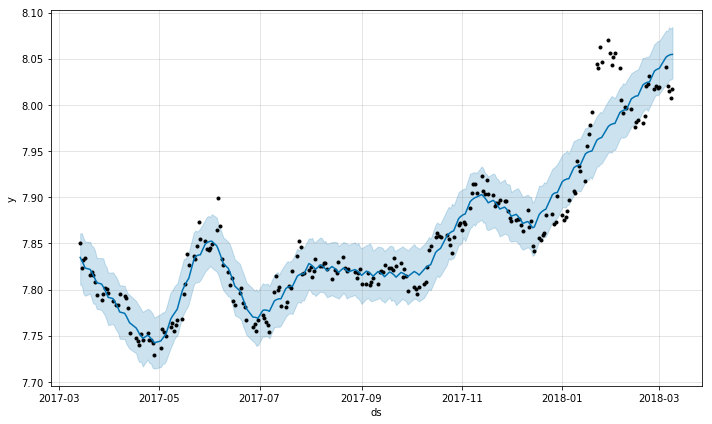

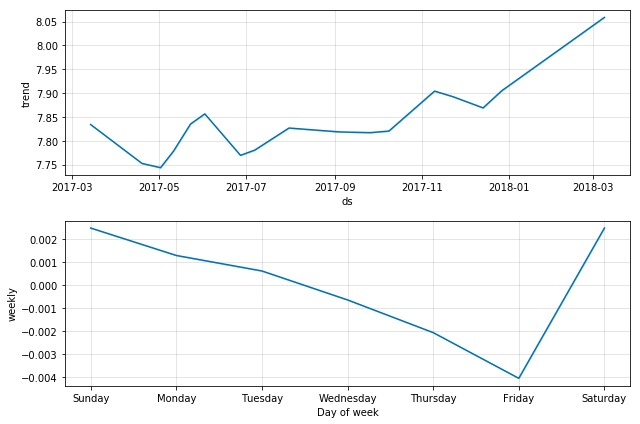

In [25]:
#Apply all functions one by one
df = pcod(df)
df = hld(df)
df = stockRsi(df, numOfDays=14)
df = bbands(df, length=20, numsd=2) 
df = stma(df, numOfDays=10) # tentatively numOfDays=10 since this is a small dataset
df = ltma(df, numOfDays=20) # tentatively numOfDays=20 since this is a small dataset
df = ema(df, numOfDays=20)
df = scul(df)
df = scll(df)

#### Few modifications done to the below 3 functions
df = stma_cuts_ltma(df)
df = close_cuts_stma(df)
df = close_cuts_ltma(df)
###################################

df = daily_returns(df)
df = daily_returns_DOWJONES(df)
df = daily_returns_NASDAQ(df)
df = daily_returns_NSE(df)
df, ts_data = TS_close_price(df)
df = beta_values(df)
df = price_movement(df)
df = vwap(df)

## time-series projections of the close price


Original 'Close' price data


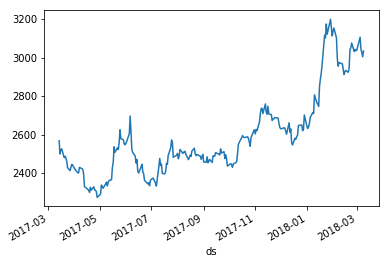

In [26]:
print("\nOriginal 'Close' price data")

ts_data.set_index('ds').y_orig.plot()


log-transformed 'Close' price data


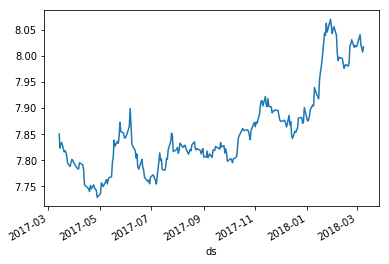

In [27]:
print("\nlog-transformed 'Close' price data")

ts_data.set_index('ds').y.plot()


time-series log-transformed 'Close' price data


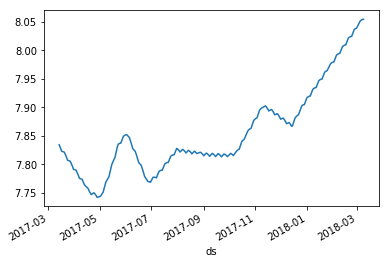

In [28]:
print("\ntime-series log-transformed 'Close' price data")

ts_data.set_index('ds').yhat.plot()

In [29]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'DOWJONES', 'NASDAQ', 'NSE', 'pcod', 'hld', 'rsi', 'bbul', 'bbll',
       'stma', 'ltma', 'ema', 'scul', 'scll', 'stma_cut_ltma_b',
       'stma_pr_cut_ltma_a', 'stma_overlaps_ltma', 'close_pr_cut_stma_b',
       'close_pr_cut_stma_a', 'close_pr_overlaps_stma', 'close_pr_cut_ltma_b',
       'close_pr_cut_ltma_a', 'close_pr_overlaps_ltma', 'dr', 'dr_dowjones',
       'dr_nasdaq', 'dr_nse', 'ds', 'TS_close_pr', 'beta', 'price_movmnt',
       'vwap'],
      dtype='object')

In [30]:
# New variables added

df[['pcod', 'hld', 'rsi', 'bbul', 'bbll', 'stma', 'ltma', 'ema', 'scul', 'scll',
    'stma_cut_ltma_b', 'stma_pr_cut_ltma_a', 'stma_overlaps_ltma', 'close_pr_cut_stma_b',
    'close_pr_cut_stma_a', 'close_pr_overlaps_stma', 'close_pr_cut_ltma_b',
    'close_pr_cut_ltma_a', 'close_pr_overlaps_ltma', 'dr', 'dr_dowjones',
    'dr_nasdaq', 'dr_nse', 'ds', 'TS_close_pr', 'beta', 'price_movmnt', 'vwap']]



,pcod,hld,rsi,bbul,bbll,stma,ltma,ema,scul,scll,...,close_pr_overlaps_ltma,dr,dr_dowjones,dr_nasdaq,dr_nse,ds,TS_close_pr,beta,price_movmnt,vwap
0,NaN,36.099853,NaN,NaN,NaN,NaN,NaN,NaN,0,0,...,0,NaN,NaN,NaN,NaN,2017-03-14,2526.851245,NaN,NaN,2567.50
1,4.500000,78.299804,NaN,NaN,NaN,NaN,NaN,NaN,0,0,...,0,-2.70,0.54,0.74,-0.02,2017-03-15,2517.960767,135.0000,0.0,2498.30
2,7.699951,21.000000,NaN,NaN,NaN,NaN,NaN,NaN,0,0,...,0,0.90,-0.07,0.01,0.76,2017-03-16,2508.693598,1.1842,1.0,2520.90
3,25.100098,36.250000,NaN,NaN,NaN,NaN,NaN,NaN,0,0,...,0,0.19,-0.10,0.00,0.07,2017-03-17,2498.046578,2.7143,1.0,2525.75
4,0.199951,59.949951,NaN,NaN,NaN,NaN,NaN,NaN,0,0,...,0,-1.81,-0.04,0.01,-0.36,2017-03-20,2494.419365,5.0278,0.0,2480.00
5,2.000000,27.000000,NaN,NaN,NaN,NaN,NaN,NaN,0,0,...,0,0.27,-1.14,-1.82,-0.06,2017-03-21,2487.096422,-4.5000,1.0,2486.70
6,-6.550049,26.050049,NaN,NaN,NaN,NaN,NaN,NaN,0,0,...,0,-0.31,-0.03,0.48,-1.00,2017-03-22,2478.345817,0.3100,0.0,2478.95
7,3.050049,37.850098,NaN,NaN,NaN,NaN,NaN,NaN,0,0,...,0,-0.75,-0.02,-0.07,0.62,2017-03-23,2469.224448,-1.2097,0.0,2460.35
8,9.449951,46.500000,NaN,NaN,NaN,NaN,NaN,NaN,0,0,...,0,-1.35,-0.29,0.19,0.24,2017-03-24,2458.744937,-5.6250,0.0,2427.20
9,-0.250000,34.000000,NaN,NaN,NaN,2485.769995,NaN,NaN,0,0,...,0,-0.62,-0.22,0.20,-0.69,2017-03-27,2455.174801,0.8986,0.0,2412.05


In [31]:
# Full dataframe

df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,DOWJONES,NASDAQ,NSE,...,close_pr_overlaps_ltma,dr,dr_dowjones,dr_nasdaq,dr_nse,ds,TS_close_pr,beta,price_movmnt,vwap
0,14-03-2017,2556.800049,2587.149902,2551.050049,2567.500000,2519.130615,1701147,20837.36914,5856.819824,9087.000000,...,0,NaN,NaN,NaN,NaN,2017-03-14,2526.851245,NaN,NaN,2567.50
1,15-03-2017,2572.000000,2572.149902,2493.850098,2498.300049,2451.234131,1511248,20950.09961,5900.049805,9084.799805,...,0,-2.70,0.54,0.74,-0.02,2017-03-15,2517.960767,135.0000,0.0,2498.30
2,16-03-2017,2506.000000,2527.000000,2506.000000,2520.899902,2473.408447,785909,20934.55078,5900.759766,9153.700195,...,0,0.90,-0.07,0.01,0.76,2017-03-16,2508.693598,1.1842,1.0,2520.90
3,17-03-2017,2546.000000,2546.000000,2509.750000,2525.750000,2478.167236,1296576,20914.61914,5901.000000,9160.049805,...,0,0.19,-0.10,0.00,0.07,2017-03-17,2498.046578,2.7143,1.0,2525.75
4,20-03-2017,2525.949951,2525.949951,2466.000000,2480.000000,2433.279297,1743770,20905.85938,5901.529785,9126.849609,...,0,-1.81,-0.04,0.01,-0.36,2017-03-20,2494.419365,5.0278,0.0,2480.00


In [32]:
# After using log transformation in Time-Series prediction, these are the values

df[['Close', 'TS_close_pr']].head(10)

,Close,TS_close_pr
0,2567.500000,2526.851245
1,2498.300049,2517.960767
2,2520.899902,2508.693598
3,2525.750000,2498.046578
4,2480.000000,2494.419365
5,2486.699951,2487.096422
6,2478.949951,2478.345817
7,2460.350098,2469.224448
8,2427.199951,2458.744937
9,2412.050049,2455.174801
